In [29]:
# import influence.csv
df_influence = pd.read_csv("data/influence.csv")
df_influence

,MEP,EPG,Country,Total Score Political Influence,Leadership,Network,Legislative,Voting performance,member.id
0,Roberta METSOLA,EPP,Malta,100.00,92.99,1.71,5.31,0.00,118859.0
1,Manfred WEBER,EPP,Germany,93.80,87.71,1.11,0.00,4.98,28229.0
2,Iratxe GARCÍA PÉREZ,S&D,Spain,82.98,74.97,2.78,0.00,5.23,28298.0
3,Othmar KARAS,EPP,Austria,71.51,43.99,2.53,20.12,4.87,4246.0
4,Valérie HAYER,Renew,France,68.41,50.34,1.31,11.51,5.25,135511.0
...,...,...,...,...,...,...,...,...,...
95,Nicolás GONZÁLEZ CASARES,S&D,Spain,39.19,3.19,2.37,28.48,5.15,NaN
96,Alexandr VONDRA,ECR,Czechia,38.72,7.01,1.09,26.80,3.82,197537.0
97,Ville NIINISTÖ,Greens/EFA,Finland,38.46,9.05,0.14,24.49,4.79,NaN
98,Jeroen LENAERS,EPP,Netherlands,38.36,15.92,1.70,15.87,4.87,95074.0


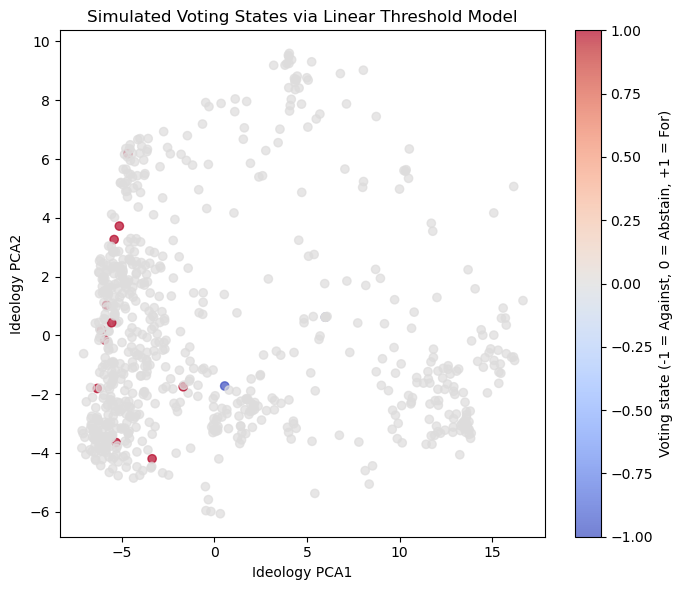

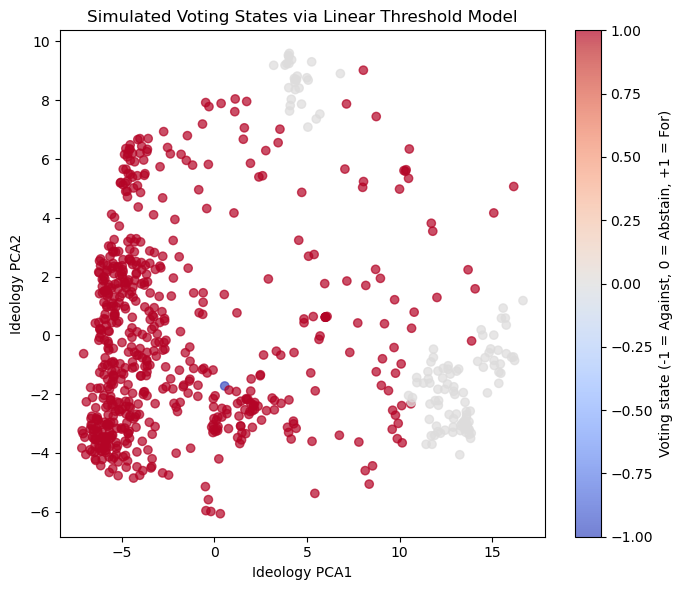

In [60]:
# ============================================================
# Multiplex Linear Threshold Model (LTM)
# ============================================================
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA


# ---------- 1. Build Layers ----------

def build_party_layer(party_ids, whip_strength=1.0):
    """
    Returns a row-normalized adjacency matrix where nodes of the same party are connected.
    """
    n = len(party_ids)
    rows, cols, data = [], [], []
    idx_by_party = {}
    for i, p in enumerate(party_ids):
        idx_by_party.setdefault(p, []).append(i)

    for members in idx_by_party.values():
        for i in members:
            for j in members:
                if i != j:
                    rows.append(i)
                    cols.append(j)
                    data.append(whip_strength)

    W = csr_matrix((data, (rows, cols)), shape=(n, n))
    return normalize(W, norm='l1', axis=1)  # Row-stochastic matrix


def build_ideology_layer(coords, sigma=1.0, kNN=15):
    """
    Builds a soft influence layer based on ideology proximity in PCA space.
    """
    n = coords.shape[0]
    nn = NearestNeighbors(n_neighbors=min(kNN, n - 1)).fit(coords)
    dists, idxs = nn.kneighbors(coords)

    rows, cols, data = [], [], []
    for i in range(n):
        for j, d in zip(idxs[i], dists[i]):
            if i == j:
                continue
            w = np.exp(-d**2 / (2 * sigma**2))
            rows.append(i)
            cols.append(j)
            data.append(w)

    W = csr_matrix((data, (rows, cols)), shape=(n, n))
    return normalize(W, norm='l1', axis=1)


def blend_layers(layers, alphas):
    """
    Combine multiple layers with given blending weights α (sum to 1).
    """
    assert len(layers) == len(alphas)
    W = sum(a * L for a, L in zip(alphas, layers))
    return normalize(W, norm='l1', axis=1)


# ---------- 2. Simulation ----------

def simulate_triLT(W, seeds_pos, seeds_neg, theta=0.35, bias=None, T=10):
    """
    Tri-state Linear Threshold Model:
    s_i ∈ {-1, 0, +1}
    """
    n = W.shape[0]
    s = np.zeros(n, dtype=int)
    s[seeds_pos] = +1
    s[seeds_neg] = -1
    b = np.zeros(n) if bias is None else np.array(bias, dtype=float)

    for _ in range(T):
        x = (W @ s.astype(float)) + b
        s_new = np.where(x >= theta, +1, np.where(x <= -theta, -1, 0))
        # Keep seeds fixed
        s_new[seeds_pos] = +1
        s_new[seeds_neg] = -1
        if np.array_equal(s_new, s):
            break
        s = s_new

    return s


if __name__ == "__main__":
    import pandas as pd
    import matplotlib.pyplot as plt

    # Example setup
    df = pd.read_csv("data/post_2024_06_09/all_votes.csv")
    party_col = "member.group.short_label"

    vote_cols = [c for c in df.columns if c.isdigit()]
    enc = {'FOR': 1, 'AGAINST': -1, 'ABSTENTION': 0, 'DID_NOT_VOTE': 0}
    M = df[vote_cols].replace(enc).fillna(0).to_numpy()
    pcs = PCA(n_components=2).fit_transform(M)
    df["_pc1"], df["_pc2"] = pcs[:, 0], pcs[:, 1]

    # Layers
    party_layer = build_party_layer(df[party_col].astype(str).values)
    ideo_layer = build_ideology_layer(df[["_pc1", "_pc2"]].to_numpy(), sigma=1.0, kNN=20)

    # Blend weights: 0.7 party, 0.3 ideology
    W = blend_layers([party_layer, ideo_layer], [0.3, 0.7])

    # take member.ids of first 20 rows of df_influence
    influential_ids = df_influence["member.id"].head(20).values

    # Map their positions in the main dataframe
    mapped_indices = []
    for mid in influential_ids:
        match = np.where(df["member.id"].astype(int) == int(mid))[0]
        if len(match) > 0:
            mapped_indices.append(match[0])

    # Split seeds by ideology (PCA1)
    seeds_pos = [i for i in mapped_indices if df.loc[i, "_pc1"] < 0]
    seeds_neg = [i for i in mapped_indices if df.loc[i, "_pc1"] >= 0]

    s_start = np.zeros(len(df))
    s_start[seeds_pos] = +1
    s_start[seeds_neg] = -1
    # plot starting seeds
    plt.figure(figsize=(7, 6))
    plt.scatter(df["_pc1"], df["_pc2"], c=s_start, cmap="coolwarm", alpha=0.7)
    plt.title("Simulated Voting States via Linear Threshold Model")
    plt.xlabel("Ideology PCA1")
    plt.ylabel("Ideology PCA2")
    plt.colorbar(label="Voting state (-1 = Against, 0 = Abstain, +1 = For)")
    plt.tight_layout()
    plt.show()

    # Simulate influence
    s_final = simulate_triLT(W, seeds_pos, seeds_neg, theta=0.1)

    # Visualize in ideology space
    plt.figure(figsize=(7, 6))
    plt.scatter(df["_pc1"], df["_pc2"], c=s_final, cmap="coolwarm", alpha=0.7)
    plt.title("Simulated Voting States via Linear Threshold Model")
    plt.xlabel("Ideology PCA1")
    plt.ylabel("Ideology PCA2")
    plt.colorbar(label="Voting state (-1 = Against, 0 = Abstain, +1 = For)")
    plt.tight_layout()
    plt.show()

In [63]:
import pandas as pd
import numpy as np
import networkx as nx
from itertools import combinations

# --- 1. Load data ---
df = pd.read_csv("data/post_2024_06_09/all_votes.csv")
vote_cols = [c for c in df.columns if c.isdigit()]
M = df[vote_cols].replace({
    'FOR': 1, 'AGAINST': -1, 'ABSTENTION': 0, 'DID_NOT_VOTE': 0
}).fillna(0).to_numpy()

mep_ids = df["member.id"].astype(str).tolist()

# --- 2. Compute pairwise agreement ---
def agreement_matrix(M):
    n = M.shape[0]
    A = np.zeros((n, n))
    for i, j in combinations(range(n), 2):
        same = np.sum(M[i] == M[j])
        total = np.sum((M[i] != 0) & (M[j] != 0))
        if total > 0:
            A[i, j] = A[j, i] = same / total
    return A

A = agreement_matrix(M)

# --- 3. Create signed network using quantile thresholds ---
low, high = np.quantile(A[A > 0], [0.25, 0.75])
G = nx.Graph()
for i in range(len(mep_ids)):
    G.add_node(mep_ids[i])
for i, j in combinations(range(len(mep_ids)), 2):
    if A[i, j] >= high:
        G.add_edge(mep_ids[i], mep_ids[j], sign=+1)
    elif A[i, j] <= low:
        G.add_edge(mep_ids[i], mep_ids[j], sign=-1)

print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
# take a subset of 100 nodes
G = G.subgraph(np.random.choice(list(G.nodes()), size=100, replace=False))

# --- 4. Approximate frustration index (heuristic) ---
def compute_frustration(G, partition):
    """Fraction of frustrated edges."""
    f = 0
    for u, v, d in G.edges(data=True):
        same = (partition[u] == partition[v])
        if (d["sign"] == 1 and not same) or (d["sign"] == -1 and same):
            f += 1
    return f / G.number_of_edges()

# initialize random partition, greedy minimization
def greedy_partition(G, k=2, max_iter=10):
    nodes = list(G.nodes())
    part = {n: np.random.randint(k) for n in nodes}
    best_f = compute_frustration(G, part)
    for _ in range(max_iter):
        improved = False
        for n in nodes:
            best_label = part[n]
            for c in range(k):
                part[n] = c
                f = compute_frustration(G, part)
                if f < best_f:
                    best_f = f
                    best_label = c
                    improved = True
            part[n] = best_label
        if not improved:
            break
    return part, best_f

partition, f = greedy_partition(G, k=2, max_iter=5)
F_norm = 1 - 2 * f  # normalized frustration index
print(f"Normalized frustration index: {F_norm:.3f}")

Graph built with 731 nodes and 135383 edges
Normalized frustration index: 0.847


In [73]:
import networkx as nx
import numpy as np

def frustration_index(G, partition):
    """Fraction of frustrated edges given a 2-block partition."""
    f = 0
    for u, v, d in G.edges(data=True):
        same = partition[u] == partition[v]
        if (d['sign'] == 1 and not same) or (d['sign'] == -1 and same):
            f += 1
    return f / G.number_of_edges()

def normalized_frustration(G, partition):
    """Normalized frustration index F(G) = 1 - 2L(G)/m"""
    f = frustration_index(G, partition)
    return 1 - 2*f

def triangle_index(G):
    """T(G) = fraction of balanced triads."""
    triads = 0
    balanced = 0
    nodes = list(G.nodes())
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            for k in range(j+1, len(nodes)):
                if G.has_edge(nodes[i], nodes[j]) and G.has_edge(nodes[j], nodes[k]) and G.has_edge(nodes[i], nodes[k]):
                    triads += 1
                    sign_product = (
                        G[nodes[i]][nodes[j]]['sign'] *
                        G[nodes[j]][nodes[k]]['sign'] *
                        G[nodes[i]][nodes[k]]['sign']
                    )
                    if sign_product == 1:
                        balanced += 1
    if triads == 0:
        return np.nan
    return balanced / triads

import pandas as pd
import numpy as np
from itertools import combinations

def build_signed_graph_from_votes(filepath):
    df = pd.read_csv(filepath)
    vote_cols = [c for c in df.columns if c.isdigit()]
    M = df[vote_cols].replace({
        'FOR': 1, 'AGAINST': -1, 'ABSTENTION': 0, 'DID_NOT_VOTE': 0
    }).fillna(0).to_numpy()
    ids = df["member.id"].astype(str).tolist()
    
    # pairwise agreement
    n = M.shape[0]
    A = np.zeros((n, n))
    for i, j in combinations(range(n), 2):
        same = np.sum(M[i] == M[j])
        total = np.sum((M[i] != 0) & (M[j] != 0))
        if total > 0:
            A[i, j] = A[j, i] = same / total
    
    # quantile thresholds
    low, high = np.quantile(A[A > 0], [0.25, 0.75])
    G = nx.Graph()
    for i in range(n):
        G.add_node(ids[i])
    for i, j in combinations(range(n), 2):
        if A[i, j] >= high:
            G.add_edge(ids[i], ids[j], sign=1)
        elif A[i, j] <= low:
            G.add_edge(ids[i], ids[j], sign=-1)
    return G

# compute for sessions
sessions = {
    "2019–2024": "data/2019_to_2024/all_votes.csv",
    "Post-2024": "data/post_2024_06_09/all_votes.csv"
}

results = []
for label, path in sessions.items():
    G = build_signed_graph_from_votes(path) 
    G = G.subgraph(np.random.choice(list(G.nodes()), size=100, replace=False))
    print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    # share of positive edges
    positive_edges = len([e for e in G.edges(data=True) if e[2]['sign'] == 1])
    print(f"Share of positive edges: {positive_edges / G.number_of_edges():.3f}")
    # simple bipartition heuristic
    partition = {n: i % 2 for i, n in enumerate(G.nodes())}
    F = normalized_frustration(G, partition)
    T = triangle_index(G)
    results.append((label, F, T))

df_results = pd.DataFrame(results, columns=["Session", "F(G)", "T(G)"])
print(df_results)

Graph built with 100 nodes and 2703 edges
Share of positive edges: 0.508
Graph built with 100 nodes and 2340 edges
Share of positive edges: 0.490
     Session      F(G)      T(G)
0  2019–2024 -0.003330  0.366649
1  Post-2024 -0.005128  0.895511


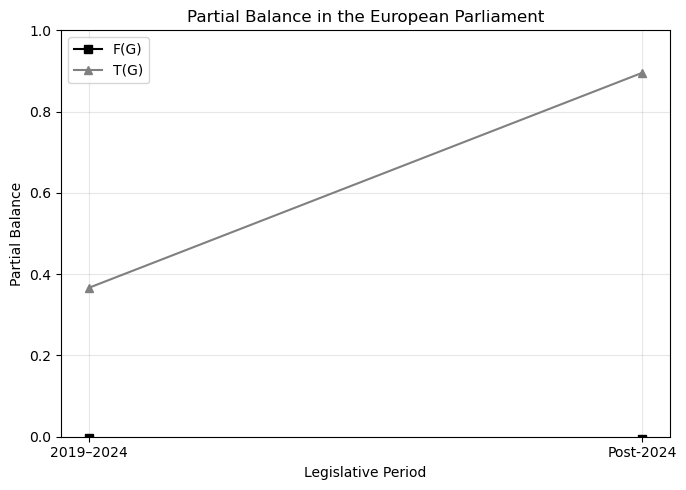

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(df_results["Session"], df_results["F(G)"], '-ks', label="F(G)")
plt.plot(df_results["Session"], df_results["T(G)"], '-^', color='gray', label="T(G)")
plt.ylim(0,1)
plt.xlabel("Legislative Period")
plt.ylabel("Partial Balance")
plt.title("Partial Balance in the European Parliament")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/wd/y6168jtx54j31_3xpbpm3srr0000gn/T/ipykernel_60328/3242070038.py:62: RuntimeWarning: divide by zero encountered in divide
  A = agree / total
/var/folders/wd/y6168jtx54j31_3xpbpm3srr0000gn/T/ipykernel_60328/3242070038.py:62: RuntimeWarning: invalid value encountered in divide
  A = agree / total
/var/folders/wd/y6168jtx54j31_3xpbpm3srr0000gn/T/ipykernel_60328/3242070038.py:39: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - 2 * (np.sum(frustrated) / np.sum(signs != 0))


A [[51.          0.40909091  5.5        ...         nan         nan
          nan]
 [ 0.40909091 48.          0.53846154 ...         nan         nan
          nan]
 [ 5.5         0.53846154  0.         ...         nan         nan
          nan]
 ...
 [        nan         nan         nan ...  0.                 nan
          nan]
 [        nan         nan         nan ...         nan  0.
          nan]
 [        nan         nan         nan ...         nan         nan
   0.        ]]
vals [0.40909091 5.5               nan ...        nan        nan        nan]
A_sign [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Window 108532-128532: F(G)=nan, T(G)=nan
A [[62.       nan -0.375 ...    nan    nan    nan]
 [   nan  0.       nan ...    nan    nan    nan]
 [-0.375    nan 53.    ...    nan    nan    nan]
 ...
 [   nan    nan    nan ...  0.       nan    nan]
 [   nan    nan    nan ...    nan  0.       nan]
 [   nan    nan  

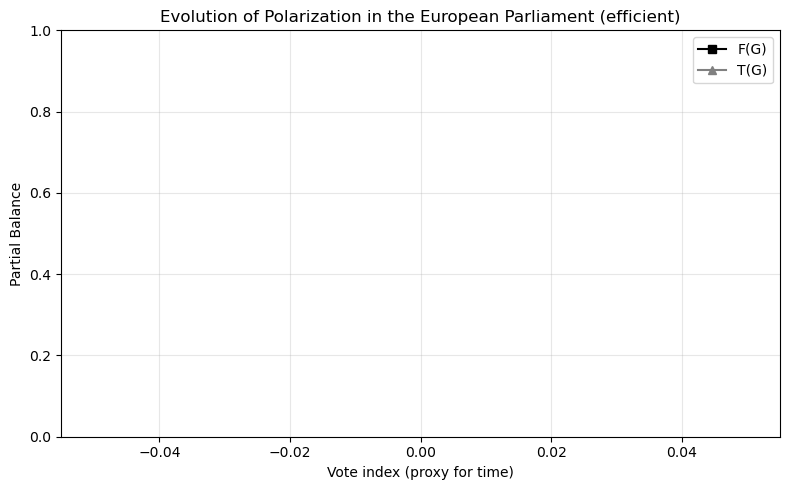

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from itertools import combinations

# ===============================================================
# 1. Load and preprocess votes
# ===============================================================
df = pd.read_csv("data/2019_to_2024/all_votes.csv")

vote_cols = [c for c in df.columns if c.isdigit()]
enc = {'FOR': 1, 'AGAINST': -1, 'ABSTENTION': 0, 'DID_NOT_VOTE': 0}
M = df[vote_cols].replace(enc).fillna(0).to_numpy().astype(np.int8)
vote_ids = np.array(vote_cols, dtype=int)
sort_idx = np.argsort(vote_ids)
M = M[:, sort_idx]
vote_ids = vote_ids[sort_idx]

n_meps = M.shape[0]
ids = df["member.id"].astype(str).values


# ===============================================================
# 2. Efficient balance metrics
# ===============================================================
def normalized_frustration_fast(A_sign, partition):
    """Vectorized frustration measure."""
    # upper triangle mask to avoid duplicates
    iu = np.triu_indices_from(A_sign, k=1)
    signs = A_sign[iu]
    if len(signs) == 0:
        return np.nan
    same = partition[iu[0]] == partition[iu[1]]
    frustrated = ((signs == 1) & (~same)) | ((signs == -1) & (same))
    return 1 - 2 * (np.sum(frustrated) / np.sum(signs != 0))


def triangle_index_fast(A_sign):
    """Approximate local balance using matrix powers (O(n^3) → O(n^2) approx)."""
    n = A_sign.shape[0]
    # Compute signed triads indirectly using matrix multiplication
    A2 = A_sign @ A_sign
    tri_sum = np.trace(A2 @ A_sign) / 6  # sum of signed triangles
    total_tri = np.sum((A_sign != 0).astype(int) @ (A_sign != 0).astype(int) * (A_sign != 0)) / 6
    return tri_sum / total_tri if total_tri > 0 else np.nan


# ===============================================================
# 3. Build signed graph (vectorized)
# ===============================================================
def build_signed_matrix(M_sub, low_q=0.25, high_q=0.75):
    # Agreement ratio (vectorized)
    valid = (M_sub != 0).astype(np.int8)
    agree = (M_sub @ M_sub.T)  # dot product gives weighted agreement
    total = valid @ valid.T
    np.fill_diagonal(total, 1)

    A = agree / total

    # Quantile thresholds
    vals = A[np.triu_indices_from(A, k=1)]
    low, high = np.quantile(vals, [low_q, high_q])
    A_sign = np.where(A >= high, 1, np.where(A <= low, -1, 0)).astype(np.int8)
    np.fill_diagonal(A_sign, 0)
    return A_sign


# ===============================================================
# 4. Sliding windows
# ===============================================================
results = []
window_size = 20000
step = 20000

# Encode parties → two blocs (rough approximation)
if "member.group.short_label" in df.columns:
    party_codes = LabelEncoder().fit_transform(df["member.group.short_label"].astype(str))
    partition = (party_codes % 2).astype(np.int8)
else:
    partition = np.arange(n_meps) % 2

for start in range(108532, 170000, step):
    end = start + window_size
    mask = (vote_ids >= start) & (vote_ids < end)
    if not mask.any():
        continue

    M_sub = M[:, mask]


    A_sign = build_signed_matrix(M_sub)

    F_val = normalized_frustration_fast(A_sign, partition)
    T_val = triangle_index_fast(A_sign)

    results.append((start, F_val, T_val))
    print(f"Window {start}-{end}: F(G)={F_val:.3f}, T(G)={T_val:.3f}")

# ===============================================================
# 5. Plot results
# ===============================================================
df_pol = pd.DataFrame(results, columns=["vote_index", "F(G)", "T(G)"]).dropna()

plt.figure(figsize=(8, 5))
plt.plot(df_pol["vote_index"], df_pol["F(G)"], "-ks", label="F(G)")
plt.plot(df_pol["vote_index"], df_pol["T(G)"], "-^", color="gray", label="T(G)")
plt.ylim(0, 1)
plt.xlabel("Vote index (proxy for time)")
plt.ylabel("Partial Balance")
plt.title("Evolution of Polarization in the European Parliament (efficient)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()